- Welcome to Quantitative and High Frequency Trading Training Program


In [4]:
from stock_helper import *
from stock_stats import *
from imp import reload   
import stock_helper
import stock_stats
reload(stock_helper)
reload(stock_stats)

<module 'stock_stats' from 'C:\\Users\\dell\\stock_stats.py'>

In [30]:
 
import warnings
 
warnings.filterwarnings('ignore')

- number of cores, set this number according to your computer

In [5]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

- sample product, you can change to your specific product symbol

In [7]:
product_list = ["600276","000538",  "600332", "600436", "600535"]

In [8]:
import dask
from dask import compute, delayed

- sample period

In [9]:
period = 4096

- choose an example day

- Now we start our new topics:
- cross-period signal
- cross-symbol signal
- arbitrage

- First, we look at cross-period signal

In [10]:
SAVE_PATH = "e:/intern"
period_list =  np.power(2, range(10,13))

- we can first generate good index of data
- because loading data each time is too time consuming

In [16]:
def get_comb_signal(date, signal_func, product, period_list, HEAD_PATH, weight):
    comb_signal = []
    n_period = len(period_list)
    total = (sum(1/period_list))
    for i in range(n_period):
        signal_name = signal_func+"."+str(period_list[i])
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+date)
        S = S*weight[i]
        if len(comb_signal)==0:
            comb_signal=S
        else:
            comb_signal += S
    save(comb_signal, HEAD_PATH+"/tmp pkl/"+product+"/"+signal_func+".comb/"+date)
    

In [17]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
len(all_signal_list)
all_comb_list = [signal+".comb" for signal in all_signal_list]
all_period_signal = [signal+".4096" for signal in all_signal_list]
weight = (1/np.sqrt(period_list))/(sum(1/np.sqrt(period_list)))

In [18]:
for product in product_list:
    for signal_func in all_signal_list:
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_func+".comb", exist_ok=True)
    

In [19]:
%%time
for product in product_list:
    all_dates = np.array(os.listdir(DATA_PATH + product))
    for signal_func in all_signal_list:
        print(product,signal_func)
        parLapply(CORE_NUM, all_dates, get_comb_signal,signal_func=signal_func,  
                  product=product, period_list=period_list,HEAD_PATH=SAVE_PATH, weight=weight)
## Wall time: 16min 11s

600276 nr
600276 dbook
600276 range.pos
600276 price.osci
600276 ma.dif.10
600276 kdj.k
600276 kdj.j
600276 nr.range
600276 dbook.range
600276 range.pos.range
600276 price.osci.range
600276 ma.dif.10.range
600276 kdj.k.range
600276 kdj.j.range
600276 nr.std
600276 dbook.std
600276 range.pos.std
600276 price.osci.std
600276 ma.dif.10.std
600276 kdj.k.std
600276 kdj.j.std
600276 nr.trend.index
600276 dbook.trend.index
600276 range.pos.trend.index
600276 price.osci.trend.index
600276 ma.dif.10.trend.index
600276 kdj.k.trend.index
600276 kdj.j.trend.index
000538 nr
000538 dbook
000538 range.pos
000538 price.osci
000538 ma.dif.10
000538 kdj.k
000538 kdj.j
000538 nr.range
000538 dbook.range
000538 range.pos.range
000538 price.osci.range
000538 ma.dif.10.range
000538 kdj.k.range
000538 kdj.j.range
000538 nr.std
000538 dbook.std
000538 range.pos.std
000538 price.osci.std
000538 ma.dif.10.std
000538 kdj.k.std
000538 kdj.j.std
000538 nr.trend.index
000538 dbook.trend.index
000538 range.pos.trend

In [21]:
## parallel generate the distribution of a signal
def par_get_all_signal(signal_name, file_list, product, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file) ## signal
        signal = S
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, SAVE_PATH+"/all signal/"+product+"."+signal_name+".pkl")

In [22]:
%%time
SAVE_PATH = "e:/intern"
for product in product_list:
    print(product)
    all_dates = os.listdir(DATA_PATH + product)
    parLapply(CORE_NUM, all_comb_list, par_get_all_signal, file_list=all_dates, product=product, period=4096, HEAD_PATH=HEAD_PATH,
             SAVE_PATH=SAVE_PATH);


# 600276
# 000538
# 600332
# 600436
# 600535
# Wall time: 29.1 s



600276
000538
600332
600436
600535
Wall time: 29.1 s


In [23]:
## this is to evalute the performance of a signal on a product
def evaluate_signal(signal, all_dates, product, min_pnl, min_num, 
                    CORE_NUM, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern", period=4096, split_str="2018", 
                    atr_filter=0, save_path="signal result",reverse=0):
    signal_name = signal+"."+str(period) ## signal name, with period
    all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+signal_name+".pkl") ## get the distribution of the signal
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001))) ## open threshold
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])): ## close threshold
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])])) ## threshold matrix
    
    if reverse>=0: ## trending signal
        print("reverse=1")
        trend_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=1, 
                                    atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SAVE_PATH=SIGNAL_PATH)
    if reverse<=0: ## reversal signal
        print("reverse=-1")
        reverse_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=-1,
                                            atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SAVE_PATH=SIGNAL_PATH)
    if reverse==0: ## both trending and reversal
        stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".pkl")
    elif reverse==1: ## just trend
        save(trend_signal_stat, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".trend.pkl")
    elif reverse==-1: ## just reversal
        save(reverse_signal_stat, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".reverse.pkl")

In [25]:
## get the statistics of backtesting a signal
from collections import OrderedDict
def get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str="2018", reverse=1, 
                     atr_filter=0, HEAD_PATH="d:/intern", SAVE_PATH="d:/intern"):
    train_sample = all_dates<split_str ## training samples
    test_sample = all_dates>split_str ## testing samples
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0] ## get training result
    train_stat = get_hft_summary(train_result, thre_mat) ## get training result statistics
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0] ## get testing result
    test_stat = get_hft_summary(test_result, thre_mat) ## get testing result statistics
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])

In [26]:
%%time
SIGNAL_PATH = "e:/intern"
for product in product_list:
    all_dates = np.array(os.listdir(DATA_PATH + product))
    for signal in all_signal_list:
        print(product, signal)
        evaluate_signal(signal, all_dates, product, 0.001, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                        period="comb", split_str="2020",atr_filter=0.02, save_path="signal result atr")

#Wall time: 9h 30min 53s


600276 nr
reverse=1
reverse=-1
600276 dbook
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600276 range.pos
reverse=1
reverse=-1
600276 price.osci
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600276 ma.dif.10
reverse=1
reverse=-1
600276 kdj.k
reverse=1
reverse=-1
600276 kdj.j
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600276 nr.range
reverse=1
reverse=-1
600276 dbook.range
reverse=1
reverse=-1
600276 range.pos.range
reverse=1
reverse=-1
600276 price.osci.range
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600276 ma.dif.10.range
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600276 kdj.k.range
reverse=1
reverse=-1
600276 kdj.j.range
reverse=1
reverse=-1
600276 nr.std
reverse=1
reverse=-1
600276 dbook.std
reverse=1
reverse=-1
600276 range.pos.std
reverse=1
reverse=-1
600276 price.osci.std
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600276 ma.dif.10.std
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600276 kdj.k.std
reverse=1
reverse=-1
600276 kdj.j.std
reverse=1
reverse=-1
600276 nr.trend.index
reverse=1
reverse=-1
600276 dbook.trend.index
reverse=1
reverse=-1
600276 range.pos.trend.index
reverse=1
reverse=-1
600276 price.osci.trend.index
reverse=1
reverse=-1
600276 ma.dif.10.trend.index
reverse=1
reverse=-1
600276 kdj.k.trend.index
reverse=1
reverse=-1
600276 kdj.j.trend.index
reverse=1
reverse=-1
000538 nr
reverse=1
reverse=-1
000538 dbook
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: divide by zero encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),
C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: divide by zero encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),
C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


000538 range.pos
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


000538 price.osci
reverse=1
reverse=-1
000538 ma.dif.10
reverse=1
reverse=-1
000538 kdj.k
reverse=1
reverse=-1
000538 kdj.j
reverse=1
reverse=-1
000538 nr.range
reverse=1
reverse=-1
000538 dbook.range
reverse=1
reverse=-1
000538 range.pos.range
reverse=1
reverse=-1
000538 price.osci.range
reverse=1
reverse=-1
000538 ma.dif.10.range
reverse=1
reverse=-1
000538 kdj.k.range
reverse=1
reverse=-1
000538 kdj.j.range
reverse=1
reverse=-1
000538 nr.std
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),
C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),
C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


000538 dbook.std
reverse=1
reverse=-1
000538 range.pos.std
reverse=1
reverse=-1
000538 price.osci.std
reverse=1
reverse=-1
000538 ma.dif.10.std
reverse=1
reverse=-1
000538 kdj.k.std
reverse=1
reverse=-1
000538 kdj.j.std
reverse=1
reverse=-1
000538 nr.trend.index
reverse=1
reverse=-1
000538 dbook.trend.index
reverse=1
reverse=-1
000538 range.pos.trend.index
reverse=1
reverse=-1
000538 price.osci.trend.index
reverse=1
reverse=-1
000538 ma.dif.10.trend.index
reverse=1
reverse=-1
000538 kdj.k.trend.index
reverse=1
reverse=-1
000538 kdj.j.trend.index
reverse=1
reverse=-1
600332 nr
reverse=1
reverse=-1
600332 dbook
reverse=1
reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),
C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600332 range.pos
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600332 price.osci
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600332 ma.dif.10
reverse=1
reverse=-1
600332 kdj.k
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600332 kdj.j
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600332 nr.range
reverse=1
reverse=-1
600332 dbook.range
reverse=1
reverse=-1
600332 range.pos.range
reverse=1
reverse=-1
600332 price.osci.range
reverse=1
reverse=-1
600332 ma.dif.10.range
reverse=1
reverse=-1
600332 kdj.k.range
reverse=1
reverse=-1
600332 kdj.j.range
reverse=1
reverse=-1
600332 nr.std
reverse=1
reverse=-1
600332 dbook.std
reverse=1
reverse=-1
600332 range.pos.std
reverse=1
reverse=-1
600332 price.osci.std
reverse=1
reverse=-1
600332 ma.dif.10.std
reverse=1
reverse=-1
600332 kdj.k.std
reverse=1
reverse=-1
600332 kdj.j.std
reverse=1
reverse=-1
600332 nr.trend.index
reverse=1
reverse=-1
600332 dbook.trend.index
reverse=1
reverse=-1
600332 range.pos.trend.index
reverse=1
reverse=-1
600332 price.osci.trend.index
reverse=1
reverse=-1
600332 ma.dif.10.trend.index
reverse=1
reverse=-1
600332 kdj.k.trend.index
reverse=1
reverse=-1
600332 kdj.j.trend.index
reverse=1
reverse=-1
600436 nr
reverse=1
reverse=-1
600436 dbook
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600436 range.pos
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: divide by zero encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: divide by zero encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600436 price.osci
reverse=1
reverse=-1
600436 ma.dif.10
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600436 kdj.k
reverse=1
reverse=-1
600436 kdj.j
reverse=1
reverse=-1
600436 nr.range
reverse=1
reverse=-1
600436 dbook.range
reverse=1
reverse=-1
600436 range.pos.range
reverse=1
reverse=-1
600436 price.osci.range
reverse=1
reverse=-1
600436 ma.dif.10.range
reverse=1
reverse=-1
600436 kdj.k.range
reverse=1
reverse=-1
600436 kdj.j.range
reverse=1
reverse=-1
600436 nr.std
reverse=1
reverse=-1
600436 dbook.std
reverse=1
reverse=-1
600436 range.pos.std
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600436 price.osci.std
reverse=1
reverse=-1
600436 ma.dif.10.std
reverse=1
reverse=-1
600436 kdj.k.std
reverse=1
reverse=-1
600436 kdj.j.std
reverse=1
reverse=-1
600436 nr.trend.index
reverse=1
reverse=-1
600436 dbook.trend.index
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600436 range.pos.trend.index
reverse=1
reverse=-1
600436 price.osci.trend.index
reverse=1
reverse=-1
600436 ma.dif.10.trend.index
reverse=1
reverse=-1
600436 kdj.k.trend.index
reverse=1
reverse=-1
600436 kdj.j.trend.index
reverse=1
reverse=-1
600535 nr
reverse=1
reverse=-1
600535 dbook
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 range.pos
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 price.osci
reverse=1
reverse=-1
600535 ma.dif.10
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 kdj.k
reverse=1
reverse=-1
600535 kdj.j
reverse=1
reverse=-1
600535 nr.range
reverse=1
reverse=-1
600535 dbook.range
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 range.pos.range
reverse=1
reverse=-1
600535 price.osci.range
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 ma.dif.10.range
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 kdj.k.range
reverse=1
reverse=-1
600535 kdj.j.range
reverse=1
reverse=-1
600535 nr.std
reverse=1
reverse=-1
600535 dbook.std
reverse=1
reverse=-1
600535 range.pos.std
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 price.osci.std
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 ma.dif.10.std
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 kdj.k.std
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 kdj.j.std
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 nr.trend.index
reverse=1
reverse=-1
600535 dbook.trend.index
reverse=1
reverse=-1
600535 range.pos.trend.index
reverse=1
reverse=-1
600535 price.osci.trend.index
reverse=1
reverse=-1
600535 ma.dif.10.trend.index
reverse=1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


reverse=-1


C:\Users\dell\stock_helper.py:189: RuntimeWarning: invalid value encountered in true_divide
  ("mar", total_ret/total_max_drawdown)]),


600535 kdj.k.trend.index
reverse=1
reverse=-1
600535 kdj.j.trend.index
reverse=1
reverse=-1
Wall time: 1d 1h 3min 56s


- now we compare the result of comb signal and previous signal

In [27]:
## get the signal performance
## including trend and reverse signals
def get_signal_performance_result(all_period_signal, signal_dire, period, product_list):
    trend_signal_result = pd.DataFrame(data=OrderedDict([("signal", all_period_signal), ("reverse",1),
                               ("num", 0), ("trainSharpe", 0), ("testSharpe", 0)]))
    reverse_signal_result = pd.DataFrame(data=OrderedDict([("signal", all_period_signal), ("reverse",-1),
                               ("num", 0), ("trainSharpe", 0), ("testSharpe", 0)]))
    n_signal = len(all_period_signal) ## number of all signals
    trend_train_sharpe = np.zeros(len(product_list))
    trend_test_sharpe = np.zeros(len(product_list))
    reverse_train_sharpe = np.zeros(len(product_list))
    reverse_test_sharpe = np.zeros(len(product_list))
    avg_pnl = 0.001
    for k in range(n_signal):
        signal_name = all_period_signal[k]
        i = 0
        for product in product_list:
            all_dates = np.array(os.listdir(DATA_PATH + product))
            train_sample = all_dates<"2019" 
            test_sample = all_dates>"2019"
            stat_result = load(HEAD_PATH+"/" + signal_dire +"/"+product+"."+signal_name+".pkl") ## statistics of signal over a product
            trend_signal_stat = stat_result['trend.signal.stat'] ## trending statistics
            
            if tuple(trend_signal_stat.keys())[0]=='train.stat':
                train_stat = trend_signal_stat["train.stat"]
                test_stat = trend_signal_stat["test.stat"]
                #good_strat = trend_signal_stat["good.strat"]
                good_strat = (train_stat["final.result"]["avg.ret"]>avg_pnl) & (train_stat["final.result"]["num"]>10)
                if sum(good_strat)>2:
                    train_stat = trend_signal_stat["train.stat"]
                    test_stat = trend_signal_stat["test.stat"]
                    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
                    #train_std = np.std(train_pnl)
                    #train_pnl = train_pnl/train_std
                    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
                    trend_train_sharpe[i] = sharpe(train_pnl)
                    trend_test_sharpe[i] = sharpe(test_pnl)
                    #print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
                    i = i+1
            if i>0: ## if there are any good products
                trend_signal_result.loc[k, ("signal", "num", "trainSharpe", "testSharpe")] = (signal_name, i,  np.mean(trend_train_sharpe[:i]),np.mean(trend_test_sharpe[:i]))
        i = 0
        for product in product_list:
            stat_result = load(HEAD_PATH+"/"+signal_dire+"/"+product+"."+signal_name+".pkl")
            reverse_signal_stat = stat_result['reverse.signal.stat']
            if tuple(reverse_signal_stat.keys())[0]=='train.stat':
                #good_strat = reverse_signal_stat["good.strat"]
                train_stat = reverse_signal_stat["train.stat"]
                train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
                test_stat = reverse_signal_stat["test.stat"]
                good_strat = (train_stat["final.result"]["avg.ret"]>avg_pnl) & (train_stat["final.result"]["num"]>10)
                test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
                if sum(good_strat)>2:
                    #train_std = np.std(train_pnl)
                    #train_pnl = train_pnl/train_std
                    reverse_train_sharpe[i] = sharpe(train_pnl)
                    reverse_test_sharpe[i] = sharpe(test_pnl)
                    i = i+1
            if i>0:
                
                reverse_signal_result.loc[k, ("signal","num", "trainSharpe", "testSharpe")] = (signal_name, i, np.mean(reverse_train_sharpe[:i]),np.mean(reverse_test_sharpe[:i]))
    return OrderedDict([("trend.signal.stat", trend_signal_result), 
                        ("reverse.signal.stat", reverse_signal_result)])


In [33]:
def get_single_signal_stat(result_atr, min_num=0, min_sharpe=0.5):
    good_trend = (result_atr["trend.signal.stat"]["num"]>min_num) & (result_atr["trend.signal.stat"]["trainSharpe"]>min_sharpe) & (result_atr["trend.signal.stat"]["testSharpe"]>min_sharpe)
    good_reverse = (result_atr["reverse.signal.stat"]["num"]>min_num) & (result_atr["reverse.signal.stat"]["trainSharpe"]>min_sharpe) & (result_atr["reverse.signal.stat"]["testSharpe"]>min_sharpe)
    print("with atr good signals: "+ str(sum(good_trend | good_reverse)))
    train_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["trainSharpe"][good_trend],
                      result_atr["reverse.signal.stat"]["trainSharpe"][good_reverse]))
    test_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["testSharpe"][good_trend],
                      result_atr["reverse.signal.stat"]["testSharpe"][good_reverse]))
    print("train sharpe: ", train_sharpe)
    print("test sharpe: ", test_sharpe)
    print(all_signal_list[good_trend])
    print(all_signal_list[good_reverse])


In [36]:
product_list

['600276', '000538', '600332', '600436', '600535']

In [31]:
result_atr = get_signal_performance_result(all_period_signal, "signal result atr", 4096, product_list)
result_comb= get_signal_performance_result(all_comb_list, "signal result atr", "comb", product_list)

In [38]:
get_single_signal_stat(result_atr, min_num=0, min_sharpe=0)
get_single_signal_stat(result_comb, min_num=0, min_sharpe=0)

#with atr good signals: 5
#train sharpe:  0.2612288725841526
#test sharpe:  0.21047517326193385
#['dbook.trend.index' 'range.pos.trend.index' 'price.osci.trend.index'
# 'kdj.k.trend.index' 'kdj.j.trend.index']
#['range.pos.trend.index' 'price.osci.trend.index']
#with atr good signals: 1
#train sharpe:  0.534989296666218
#test sharpe:  0.7477157487691811
#['dbook.trend.index']
#['dbook.trend.index']




with atr good signals: 5
train sharpe:  0.2612288725841526
test sharpe:  0.21047517326193385
['dbook.trend.index' 'range.pos.trend.index' 'price.osci.trend.index'
 'kdj.k.trend.index' 'kdj.j.trend.index']
['range.pos.trend.index' 'price.osci.trend.index']
with atr good signals: 1
train sharpe:  0.534989296666218
test sharpe:  0.7477157487691811
['dbook.trend.index']
['dbook.trend.index']


In [39]:
get_single_signal_stat(result_atr, min_num=1, min_sharpe=0)
get_single_signal_stat(result_comb, min_num=1, min_sharpe=0)

#with atr good signals: 5
#train sharpe:  0.2612288725841526
#test sharpe:  0.21047517326193385
#['dbook.trend.index' 'range.pos.trend.index' 'price.osci.trend.index'
# 'kdj.k.trend.index' 'kdj.j.trend.index']
#['range.pos.trend.index' 'price.osci.trend.index']
#with atr good signals: 1
#train sharpe:  0.534989296666218
#test sharpe:  0.7477157487691811
#['dbook.trend.index']
#['dbook.trend.index']



with atr good signals: 5
train sharpe:  0.2612288725841526
test sharpe:  0.21047517326193385
['dbook.trend.index' 'range.pos.trend.index' 'price.osci.trend.index'
 'kdj.k.trend.index' 'kdj.j.trend.index']
['range.pos.trend.index' 'price.osci.trend.index']
with atr good signals: 1
train sharpe:  0.534989296666218
test sharpe:  0.7477157487691811
['dbook.trend.index']
['dbook.trend.index']


- the signal with combination is worse than the signal with just 4096 period

- we can see that with atr fitler the result is a little bit worse 
- also we can see that signal of 4096 ticks perform better than combination of signals
- maybe we can use strategies of each period (1024/2048/4096) and then combine them together
- rather than combine them first and then construct strategies
- now we go to cross-symbol signals and arbitrage

In [41]:
product_x = "600276"
product_y = "600332"
date = "2018.pkl"
SAVE_PATH = "e:/intern"
data_x = load(HEAD_PATH+"/stock pkl/"+product_x+"/"+date)
data_y = load(HEAD_PATH+"/stock pkl/"+product_y+"/"+date)

In [46]:
data_x["date.time"]

0          2018-01-02 09:25:01
1          2018-01-02 09:30:00
2          2018-01-02 09:30:02
3          2018-01-02 09:30:06
4          2018-01-02 09:30:12
                  ...         
1073071    2018-12-28 14:56:48
1073072    2018-12-28 14:56:51
1073073    2018-12-28 14:56:54
1073074    2018-12-28 14:56:57
1073075    2018-12-28 15:00:00
Name: date.time, Length: 1073076, dtype: object

In [47]:
data_y["date.time"]

0         2018-01-08 09:25:02
1         2018-01-08 09:30:01
2         2018-01-08 09:30:03
3         2018-01-08 09:30:07
4         2018-01-08 09:30:10
                 ...         
875995    2018-12-28 14:56:44
875996    2018-12-28 14:56:47
875997    2018-12-28 14:56:53
875998    2018-12-28 14:56:59
875999    2018-12-28 15:00:00
Name: date.time, Length: 876000, dtype: object

In [42]:
os.makedirs(HEAD_PATH+"/comb time", exist_ok=True)
os.makedirs(HEAD_PATH+"/comb time/"+product_x+"_"+product_y, exist_ok=True)

In [43]:
all_dates_x = os.listdir(DATA_PATH + product_x)
all_dates_y = os.listdir(DATA_PATH + product_y)
all_dates = set(all_dates_x) & set(all_dates_y)
all_dates = np.array(list(all_dates))
all_dates.sort()

In [50]:
from collections import Counter
def get_stock_comb_pos(date, product_x, product_y, HEAD_PATH):
    data_x = load(HEAD_PATH+"/stock pkl/"+product_x+"/"+date)
    data_y = load(HEAD_PATH+"/stock pkl/"+product_y+"/"+date)
    data_x["contract"] = product_x
    data_y["contract"] = product_y
    comb_time = np.append(data_x["date.time"], data_y["date.time"])
    sort_index = np.argsort(comb_time)
    comb_time = comb_time[sort_index]    
    data = data_x.append(data_y)
    data = data.iloc[sort_index,:]
    time_x = data["contract"]==product_x
    time_y = data["contract"]==product_y
    save([sort_index, time_x, time_y], HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+date)

In [51]:
%%time
result = parLapply(CORE_NUM, all_dates, get_stock_comb_pos, product_x=product_x, product_y=product_y, HEAD_PATH=HEAD_PATH)

#Wall time:  2min 17s

Wall time: 17.1 s


- let's go to arbitrage

In [52]:
def par_get_stock_arb_all_signal(signal_name, file_list, product_x, product_y, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
        S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
        [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
        extend_x = np.append(S_x,S_y)
        extend_x[time_y] = np.nan
        extend_y = np.append(S_x,S_y)
        extend_y[time_x] = np.nan
        extend_x[0] = S_x[0]
        extend_y[0] = S_y[0]
        extend_x = pd.DataFrame(extend_x)
        extend_y = pd.DataFrame(extend_y)
        extend_x.ffill(inplace=True)
        extend_y.ffill(inplace=True)
        signal = np.array((extend_x-extend_y)[0])
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, HEAD_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [53]:
%%time
result = par_get_stock_arb_all_signal("kdj.j.4096",  file_list=all_dates, product_x=product_x, 
                   product_y = product_y, period=4096, HEAD_PATH=HEAD_PATH, SAVE_PATH = SAVE_PATH)

# Wall time:  1min 6s

Wall time: 4.34 s


In [134]:
def get_combine_data(file, product_x, product_y, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    data_x = load(HEAD_PATH+"/stock pkl/"+product_x+"/"+file)
    data_y = load(HEAD_PATH+"/stock pkl/"+product_y+"/"+file)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    extend_data_x = data_x.append(data_y)
    extend_data_x = extend_data_x.reset_index(drop=True)
    extend_data_x = extend_data_x.iloc[sort_index]
    extend_data_x = extend_data_x.reset_index(drop=True)
    extend_data_x.loc[list(time_y), ("bid1", "ask1", "next.bid", "next.ask", "adjust", "wpr")] = np.nan
    extend_data_x.loc[0] = data_x.loc[0]
    extend_data_x.ffill(inplace=True)
    extend_data_y = data_x.append(data_y)
    extend_data_y = extend_data_y.reset_index(drop=True)
    extend_data_y = extend_data_y.iloc[sort_index]
    extend_data_y = extend_data_y.reset_index(drop=True)
    extend_data_y.loc[list(time_x), ("bid1", "ask1", "next.bid", "next.ask", "adjust", "wpr")] = np.nan
    extend_data_y.loc[0] = data_y.iloc[0]
    extend_data_y.ffill(inplace=True)
    data = extend_data_x.loc[:,("date.time", "bid1", "ask1", "next.bid", "next.ask", "adjust", "wpr")]
    data["y.bid"] = extend_data_y["bid1"].values
    data["y.ask"] = extend_data_y["ask1"].values
    data["y.next.bid"] = extend_data_y["next.bid"].values
    data["y.next.ask"] = extend_data_y["next.ask"].values
    data["y.adjust"] = extend_data_y["adjust"].values
    data["y.wpr"] = extend_data_y["wpr"].values
    save(data, HEAD_PATH+"/stock pkl/"+product_x+"_"+product_y+"/"+file)

In [135]:
os.makedirs(HEAD_PATH+"/stock pkl/"+product_x+"_"+product_y, exist_ok=True)

In [136]:
%%time
result = parLapply(CORE_NUM, all_dates, get_combine_data, product_x=product_x, product_y = product_y, 
                   HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH);

# Wall time: 28.5 s


Wall time: 28.5 s


In [137]:
data = load(HEAD_PATH+"/stock pkl/"+product_x+"_"+product_y+"/"+all_dates[0])

In [138]:
data

,date.time,bid1,ask1,next.bid,next.ask,adjust,wpr,y.bid,y.ask,y.next.bid,y.next.ask,y.adjust,y.wpr
0,2016-01-04 09:25:04,49.06,49.10,49.06,49.10,1.000000,49.073333,30.05,30.27,30.16,30.27,1.0,30.090526
1,2016-01-04 09:25:04,49.06,49.10,49.06,49.10,1.000000,49.073333,30.05,30.27,30.16,30.27,1.0,30.090526
2,2016-01-04 09:30:01,49.06,49.10,49.01,49.06,1.000000,49.074545,30.05,30.27,30.16,30.27,1.0,30.090526
3,2016-01-04 09:30:02,49.06,49.10,49.01,49.06,1.000000,49.074545,30.16,30.27,30.16,30.25,1.0,30.204468
4,2016-01-04 09:30:03,49.06,49.10,49.01,49.06,1.000000,49.074545,30.16,30.25,30.16,30.25,1.0,30.205738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215084,2016-12-30 14:59:51,45.50,45.52,45.50,45.52,1.198509,54.555208,23.97,23.98,23.97,23.98,1.0,23.970179
1215085,2016-12-30 14:59:57,45.50,45.52,45.50,45.52,1.198509,54.555208,23.97,23.98,23.97,23.98,1.0,23.970119
1215086,2016-12-30 14:59:57,45.50,45.52,45.52,45.54,1.198509,54.555096,23.97,23.98,23.97,23.98,1.0,23.970119
1215087,2016-12-30 15:00:00,45.52,45.54,45.52,45.54,1.198509,54.579119,23.97,23.98,23.97,23.98,1.0,23.970119


In [156]:
from collections import OrderedDict
def get_stock_cross_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1,  buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                   max_spread=0.011,HEAD_PATH="d:/intern", SAVE_PATH="e:/intern",
                   atr_filter=0):
    ## load data
    data = load(HEAD_PATH+"/stock pkl/"+product_x+"_"+product_y+"/"+file)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
    S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
    extend_x = np.append(S_x, S_y)
    extend_x = extend_x[sort_index]
    extend_x[time_y] = np.nan
    extend_x[0] = S_x[0]
    extend_x = pd.DataFrame(extend_x)
    extend_x.ffill(inplace=True)
    atr_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+"atr.4096"+"/"+file).reset_index(drop=True)
    atr_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+"atr.4096"+"/"+file).reset_index(drop=True)
    extend_atr_x = np.append(atr_x, atr_y)
    extend_atr_x = extend_atr_x[sort_index]
    extend_atr_x[time_y] = np.nan
    extend_atr_x[0] = atr_x[0]
    extend_atr_x = pd.DataFrame(extend_atr_x)
    extend_atr_x.ffill(inplace=True)
    atr = extend_atr_x
    S = extend_x
    pred = S*reverse
    pred = pred[0]
    data_x = np.nan
    data_y = np.nan
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread = data["y.ask"]-data["y.bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["y.next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["y.next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["y.next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["y.next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base[change_buy] = data["y.next.ask"][change_buy]*(1+buy_tranct)*data["y.adjust"]
        change_base[change_sell] = data["y.next.bid"][change_sell]*(1-sell_tranct)*data["y.adjust"]
        raw_pnl = -(change_base*notional_change_pos).cumsum()+notional_position*data["wpr"]
        final_pnl = -sum(change_base*notional_change_pos) ## total pnl, there is a negative sign, because selling get money and buying pay money
        turnover = sum(change_base*abs(notional_change_pos))
        num = sum((notional_position!=0) & (notional_change_pos!=0)) ## number of trades
        hld_period = sum(position!=0)   ## holding period
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, final_pnl/num, final_pnl)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])


In [157]:
signal_name = "kdj.j.4096" 

In [158]:
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


In [159]:
from collections import OrderedDict
def get_stock_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2019", reverse=1, 
                                 buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                    max_spread=0.011,  HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", min_pnl=2, min_num=20, atr_filter=0):
    train_sample = all_dates<split_str
    test_sample = all_dates>split_str
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_stock_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, buy_tranct=buy_tranct, sell_tranct=sell_tranct, max_spread=max_spread, 
                                  HEAD_PATH=HEAD_PATH,
                                  SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0]
    train_stat = get_hft_summary(train_result, thre_mat)
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_stock_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                  reverse=reverse, buy_tranct=buy_tranct, sell_tranct=sell_tranct, max_spread=max_spread, 
                                  HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,
                                  atr_filter=atr_filter)
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0]
    test_stat = get_hft_summary(test_result, thre_mat)
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])

In [160]:
def evaluate_stock_cross_signal(signal, all_dates, product_x, product_y, min_pnl, min_num, HEAD_PATH, SAVE_PATH,
                    CORE_NUM, period=4096, split_str="2018", buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                    max_spread=0.011, atr_filter=0, save_path="signal result"):
    signal_name = signal+"."+str(period)
    all_signal = load(SAVE_PATH+"/all signal/"+product_x+"."+signal_name+".pkl")
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    print("reverse=1")
    trend_signal_stat = get_stock_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str=split_str, reverse=1, 
                    max_spread=max_spread, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    print("reverse=-1")
    reverse_signal_stat = get_stock_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str=split_str, reverse=-1, 
                    max_spread=max_spread, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,  min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
    save(stat_result, HEAD_PATH+"/"+save_path+"/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [161]:
%%time
result = evaluate_stock_cross_signal("kdj.j", np.array(list(all_dates)), product_x,product_y, 2, 20, HEAD_PATH, SAVE_PATH,
                CORE_NUM, period=4096, split_str="2019", atr_filter=0.02, save_path="signal result atr")

# reverse=1
# reverse=-1
# Wall time: 18min 19s





reverse=1
reverse=-1
Wall time: 18min 35s


In [162]:
result = load(HEAD_PATH+"/signal result atr/"+product_x+"_"+product_y+".kdj.j.4096.pkl")

0.024274977406414325 -0.008329860439665113


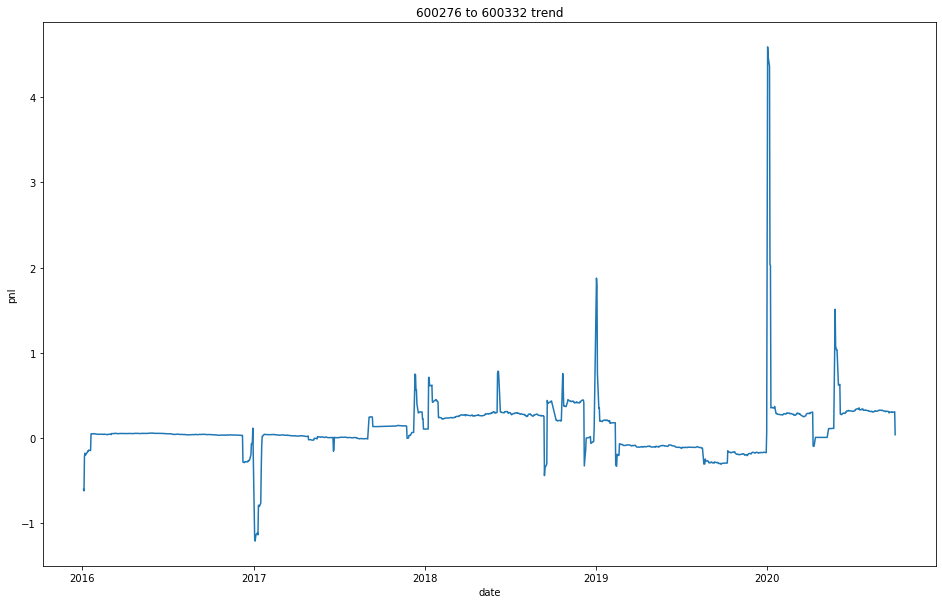

In [163]:
train_stat =result["trend.signal.stat"]["train.stat"]
train_sample = all_dates<"2019"
test_sample = all_dates>"2019"
train_dates = np.array([pd.to_datetime(d) for d in train_stat["date"]])
good_strat = (train_stat["final.result"]["avg.ret"]>0.001) & (train_stat["final.result"]["num"]>0)
train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
test_stat =result["reverse.signal.stat"]["test.stat"]
test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
test_dates = np.array([pd.to_datetime(d) for d in test_stat["date"]])
format_dates = np.append(train_dates, test_dates)
pnl = np.append(train_pnl, test_pnl)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title(product_x+" to "+product_y+" trend");
plt.plot(format_dates, pnl.cumsum());
#plt.plot(format_dates[test_sample], pnl.cumsum()[test_sample])
print(sharpe(train_pnl), sharpe(test_pnl))
# 0.024274977406414325 -0.008329860439665113


- we can see that strategies in training set can still perform well in test set

In [225]:
## backtest arbitrage signal strategy
## each time buy a product and sell another
## long the pair means long product x and short product y with the same notional value
from collections import OrderedDict
def get_stock_arb_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                             max_spread_x=0.011, max_spread_y=0.011,HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", 
                             rebate=0, signal_thre=11e-4):
    ## load data
    data = load(HEAD_PATH+"/stock pkl/"+product_x+"_"+product_y+"/"+file)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    ## load signals
    S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
    S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
    [sort_index, time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    extend_x = np.append(S_x,S_y)
    extend_x[time_y] = np.nan
    extend_y = np.append(S_x,S_y)
    extend_y[time_x] = np.nan
    extend_x[0] = S_x[0]
    extend_y[0] = S_y[0]
    extend_x = pd.DataFrame(extend_x)
    extend_y = pd.DataFrame(extend_y)
    extend_x.ffill(inplace=True)
    extend_y.ffill(inplace=True)
    S = np.array((extend_x-extend_y)[0]) ## difference of two signals
    pred = S*reverse
    #pred = pred[data["good"]].reset_index(drop=True)[0]
    data = data.reset_index(drop=True) 
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    data_x = np.nan
    data_y = np.nan
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                            ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread_x = data["ask1"]-data["bid1"]
    cur_spread_y = data["y.ask"]-data["y.bid"]
    n_bar = len(data)
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        ## long means buy product x at next.ask and sell product y at next bid
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread_y<max_spread_y)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (data["y.next.ask"]>0) & (cur_spread_x<max_spread_x) &
                    (cur_spread_y<max_spread_y)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos_x = pd.Series(data=0, index=data.index)
        notional_position_pos_y = pd.Series(data=0, index=data.index)
        notional_position_pos_x[position_pos==1] = 1
        notional_position_pos_x[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos_y[position_pos==1] = 1
        notional_position_pos_y[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos_x[(notional_position_pos_x==1)] = 1/data["next.ask"][(notional_position_pos_x==1)]
        notional_position_pos_y[(notional_position_pos_y==1)] = -1/data["y.next.bid"][(notional_position_pos_y==1)]
        notional_position_pos_x.ffill(inplace=True)
        notional_position_pos_y.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        ## short means sell product x at next.bid and buy product y at next ask
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data["y.next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread_y<max_spread_y)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (data["y.next.bid"]>0) & (cur_spread_y<max_spread_y)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg_x = pd.Series(data=0, index=data.index)
        notional_position_neg_y = pd.Series(data=0, index=data.index)
        notional_position_neg_x[position_neg==-1] = -1
        notional_position_neg_x[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg_y[position_neg==-1] = -1
        notional_position_neg_y[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg_x[(notional_position_neg_x==-1)] = -1/data["next.bid"][(notional_position_neg_x==-1)]
        notional_position_neg_y[(notional_position_neg_y==-1)] = 1/data["y.next.ask"][(notional_position_neg_y==-1)]
        notional_position_neg_x.ffill(inplace=True)
        notional_position_neg_y.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position_x = notional_position_pos_x+notional_position_neg_x
        notional_position_y = notional_position_pos_y+notional_position_neg_y
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        notional_position_x.iloc[0] = 0
        notional_position_y.iloc[0] = 0
        notional_position_x.iloc[-10:] = 0
        notional_position_y.iloc[-10:] = 0
        notional_change_pos_x = notional_position_x-notional_position_x.shift(1)
        notional_change_pos_y = notional_position_y-notional_position_y.shift(1)
        change_pos = position - position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos_x.iloc[0] = 0
        notional_change_pos_y.iloc[0] = 0
        change_base_x = pd.Series(data=0, index=data.index)
        change_base_y = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base_x[change_buy] = data["next.ask"][change_buy]*(1+buy_tranct)*data["adjust"]
        change_base_x[change_sell] = data["next.bid"][change_sell]*(1-sell_tranct)*data["adjust"]
        change_base_y[change_buy] = data["y.next.bid"][change_buy]*(1-sell_tranct)*data["y.adjust"]
        change_base_y[change_sell] = data["y.next.ask"][change_sell]*(1+buy_tranct)*data["y.adjust"]
        final_pnl = -sum(change_base_x*change_pos)-sum(change_base_y*change_pos)
        ret = -sum(change_base_x*notional_change_pos_x)-sum(change_base_y*notional_change_pos_y)
        raw_pnl = -(change_base_x*notional_change_pos_x).cumsum()+notional_position_x*data["wpr"]-(change_base_y*notional_change_pos_y).cumsum()+notional_position_y*data["y.wpr"]
        num = sum((position!=0) & (change_pos!=0))
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, ret/num, ret)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])

In [216]:
signal_name = "kdj.j.4096" 
product_x = "600276"
product_y = "600332"
thre_list = []
#open_list = np.quantile(abs(all_signal), np.arange(0.99991,0.99999,0.00001))
open_list = np.arange(0.003,0.005,0.0001)
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat

,open,close
0,0.0030,-0.00060
1,0.0030,-0.00120
2,0.0030,-0.00180
3,0.0030,-0.00240
4,0.0030,-0.00300
...,...,...
95,0.0049,-0.00098
96,0.0049,-0.00196
97,0.0049,-0.00294
98,0.0049,-0.00392


In [226]:
%%time
train_result = parLapply(CORE_NUM, all_dates[train_sample], get_stock_arb_signal_pnl, product_x=product_x, product_y=product_y, 
                         signal_name="kdj.j.4096", thre_mat=thre_mat, reverse=1, buy_tranct=1.5e-4, sell_tranct=11.5e-4, 
                         max_spread_x=0.011, max_spread_y=0.011, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern")
test_result = parLapply(CORE_NUM, all_dates[test_sample], get_stock_arb_signal_pnl, product_x=product_x, product_y=product_y, 
                        signal_name="kdj.j.4096",
                        thre_mat=thre_mat, reverse=1, buy_tranct=1.5e-4, sell_tranct=11.5e-4, 
                         max_spread_x=0.011, max_spread_y=0.011, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern")
# Wall time: 14min 40s

Wall time: 14min 46s


In [227]:
train_stat = get_hft_summary(train_result, thre_mat)
test_stat = get_hft_summary(test_result, thre_mat)

In [228]:
save(train_stat, HEAD_PATH+"/stock.arb.train.pkl")
save(test_stat, HEAD_PATH+"/stock.arb.test.pkl")

- we can see that there are no good strategies for a-m arbitrage
- the reason may be that oil contracts have too low volatility and intraday trading cannot cover transaction cost


0.5587586617272303 0.765006599306317


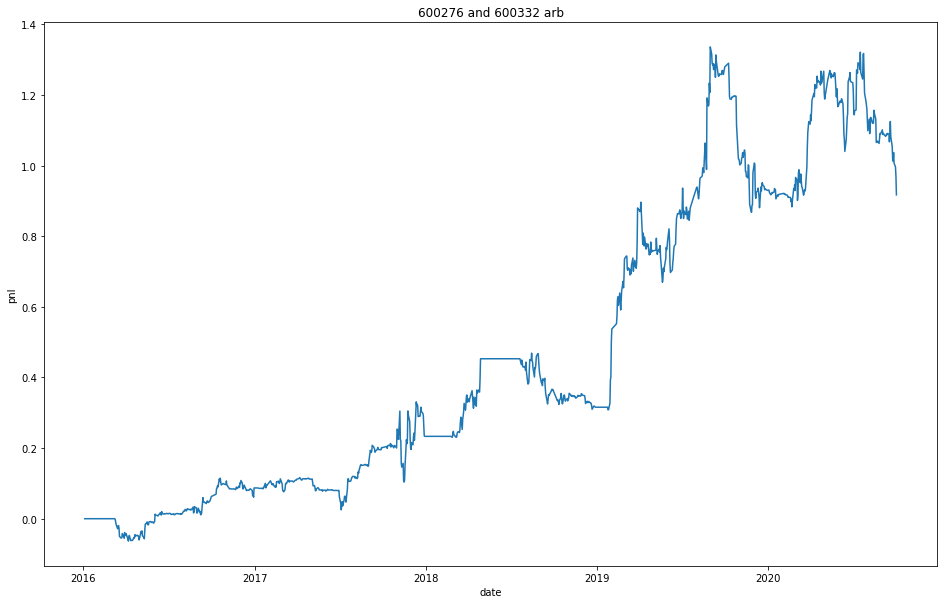

In [230]:
date_str = [n[0:10] for n in all_dates]
train_sample = all_dates<"2019"
test_sample = all_dates>"2019"
good_strat = (train_stat["final.result"]["avg.ret"]>0.001) & (train_stat["final.result"]["num"]>0)
train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
train_dates = np.array([pd.to_datetime(d) for d in train_stat["date"]])
test_dates = np.array([pd.to_datetime(d) for d in test_stat["date"]])
format_dates = np.append(train_dates, test_dates)
pnl = np.append(train_pnl, test_pnl)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title(product_x+" and "+product_y+" arb");
plt.plot(format_dates, pnl.cumsum());
print(sharpe(train_pnl), sharpe(test_pnl))
